# 🕵🏻‍♂️ Analýza postav ze seriálu Dark

<sup>BI-VIZ @ FIT CTU </sup>

V tomto Jupyter Notebooku 📖 si ukážeme základní analýzu sociální sítě postav ze seriálu [Dark](https://www.csfd.cz/film/496803-dark/prehled/) pomocí knihoven [NetworkX](https://networkx.org/documentation/stable/index.html), [nxViz](https://pypi.org/project/nxviz/) a [Netwulf](https://netwulf.readthedocs.io/en/latest/).

Zdrojová data jsou k dispozici na [Kaggle](https://www.kaggle.com/datasets/deepcontractor/dark-netflix-character-relationship), ale pro toto cvičení prošla ještě čištěním a úpravami.

<img width=900 height=800 src="https://i.redd.it/3nypv8br5f301.jpg"/>

In [1]:
%matplotlib inline

In [2]:
import collections
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=DeprecationWarning)
warnings.simplefilter(action="ignore", category=UserWarning)
import re
import math
import json
from pprint import pprint

In [3]:
from nxviz import annotate

In [4]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import pandas as pd
import numpy as np
import networkx as nx
import nxviz as nv
import netwulf as nw

import seaborn as sns
import matplotlib.animation
import ipywidgets as widgets

In [5]:
with open("characters2.json", "r") as f:
    data = json.loads(f.read())
    df = pd.read_json(json.dumps(data))
df.head()

,name,lastname,years,parentOf,parents,married,siblings
0,Daniel Kahnwald,Kahnwald,[1953],[Ines Kahnwald],None,None,None
1,Ines Kahnwald,Kahnwald,"[1953, 1986, 2019]",[Mikkel Nielsen],[Daniel Kahnwald],None,None
2,Hannah Kahnwald,Kahnwald,"[1986, 2019]",[Jonas Kahnwald],None,[Mikkel Nielsen],None
3,Jonas Kahnwald,Kahnwald,"[1921, 1953, 1986, 2019, 2052, 2085]",None,"[Hannah Kahnwald, Mikkel Nielsen]",None,None
4,Ulrich Nielsen,Nielsen,"[1953, 1986, 2019]","[Mikkel Nielsen, Martha Nielsen, Magnus Nielsen]","[Tronte Nielsen, Jana Nielsen]",[Katharina Nielsen],[Mads Nielsen]


## ⚙️ Zpracování dat

Dataset obsahuje jména (`name`) jednotlivých postav ze seriálu Dark, jejich příjmení (`lastname`), seznam let, ve kterých se daná postava vyskytovala (`years`), čí je rodič (`parentOf`), kdo je jeho rodič (`parents`), s kým je sezdán (`married`) a kdo je jeho sourozenec (`siblings`). 👨‍👨‍👧‍👦👩‍👩‍👧‍👦👨‍👩‍👧‍👦 (_Pardon za univerzální mužský rod._)

Z náhledu výše můžeme vidět, že některé sloupce obsahují řádky s různými datovými typy. 🙈 Převážně se míchají `List[str]` a `None`. Budeme muset nahradit chybějící hodnoty - nemůžeme použít `df.fillna([])`, a tak to budeme muset udělat ručně 💪 (případně můžete najít i jiná řešení, např. na Stackoverflow).

In [6]:
def preprocess(row: pd.Series):
    columns = list(row.values)
    for i, x in enumerate(columns):

        if isinstance(x, list):
            continue

        if isinstance(x, str):
            # keep the first two string columns, then wrap it with list
            if i > 1:
                columns[i] = [x]
        else:
            # None values -> empty list
            columns[i] = []

    return columns

In [7]:
name, lastname, years, parentOf, parents, married, siblings = preprocess(df.iloc[2])
name, lastname, years, parentOf, parents, married, siblings

('Hannah Kahnwald',
 'Kahnwald',
 [1986, 2019],
 ['Jonas Kahnwald'],
 [],
 ['Mikkel Nielsen'],
 [])

Pojďme si z poskytnutých dat vytvořit dva orientované grafy - jeden pro vztahy 👯, druhý pro "existenci v čase" 🕰:

In [8]:
family_graph = nx.DiGraph()
year_graph = nx.DiGraph()

# create id mapping to lastnames
lastname_dict = {x: i * 100 for i, x in enumerate(set(df.lastname.values))}

for i, row in df.iterrows():
    name, lastname, years, parentOf, parents, married, siblings = preprocess(row)

    # add person to graph
    family_graph.add_node(
        name,
        name=name,
        name_key=i,
        lastname=lastname,
        lastname_key=lastname_dict[lastname],
    )
    # add links to years
    for i, year in enumerate(years):
        year_graph.add_node(year, year=year, g=0, name=str(year))
        year_graph.add_edge(year, name, i=i + 1, w=7, y=year)
    year_graph.add_node(
        name,
        year=lastname_dict[lastname],
        g=1 if len(years) < 2 else 2,
        name=name,
        lastname=lastname,
    )

    # add node->children edges
    for child in parentOf:
        family_graph.add_edge(name, child, kind="parent_of", kind_id=0, w=5)
        family_graph.add_edge(child, name, kind="child_of", kind_id=1, w=5)

    # add node->parent edges
    for parent in parents:
        family_graph.add_edge(name, parent, kind="child_of", kind_id=1, w=5)
        family_graph.add_edge(parent, name, kind="parent_of", kind_id=0, w=5)

    # add sibling edges
    for sibling in siblings:
        family_graph.add_edge(name, sibling, kind="sibling_of", kind_id=2, w=5)
        family_graph.add_edge(sibling, name, kind="sibling_of", kind_id=2, w=5)

    # add partner edges
    for partner in married:
        family_graph.add_edge(name, partner, kind="married_to", kind_id=3, w=5)
        family_graph.add_edge(partner, name, kind="married_to", kind_id=3, w=5)

for node, attr in family_graph.nodes(data=True):
    attr["degree"] = family_graph.degree[node]

In [9]:
#family_graph.nodes(data=True)
#year_graph.nodes(data=True)

## 🧸 Relace mezi rodinami jako matice přechodů

Trochu dramatický popis `Matrix Plot` lze nalézt [zde](https://ericmjl.github.io/nxviz/developers/new-plots/).

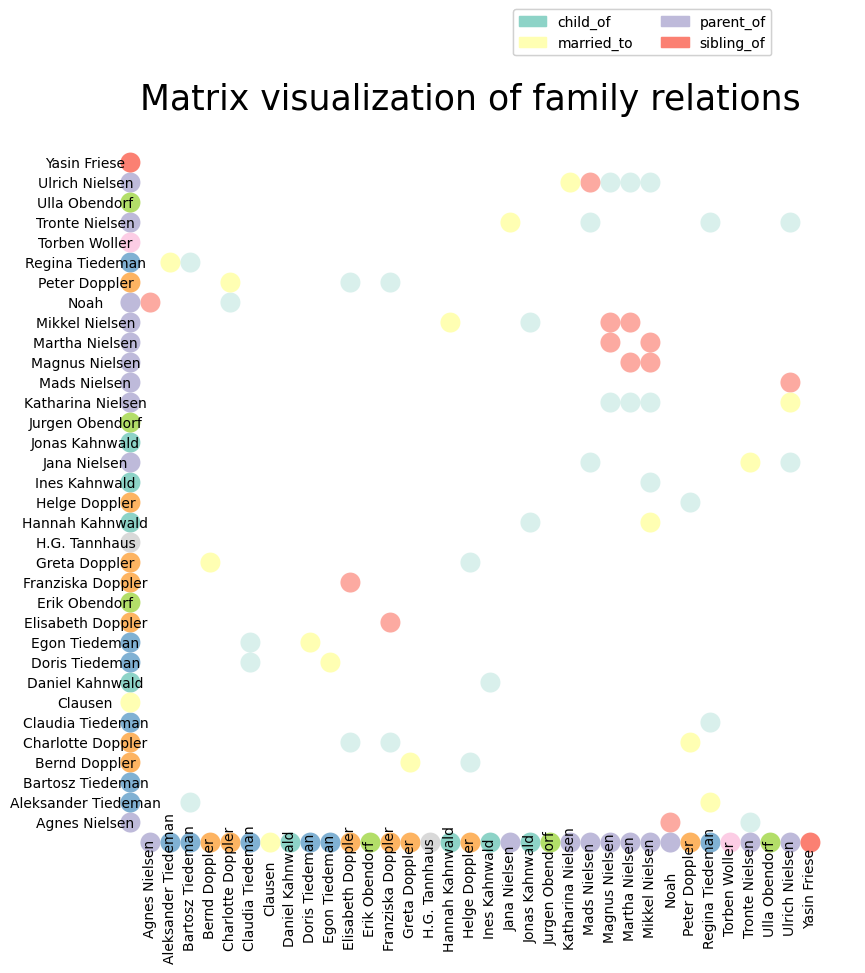

In [10]:
fig = plt.figure(figsize=(10, 10))
ax = plt.gca()
plt.title("Matrix visualization of family relations", fontsize=25)
nv.matrix(
    family_graph,
    group_by="name",
    node_color_by="lastname_key",
    edge_alpha_by="kind_id",
    sort_by="lastname_key",
    edge_color_by="kind",
)
annotate.matrix_group(
    family_graph,
    group_by="name",
    xrotation=90,
    ax=ax,
    yrotation=0,
    offset=-4.5,
)

annotate.edge_colormapping(
    family_graph,
    color_by="kind",
    ax=ax,
    legend_kwargs={"loc": "upper right", "bbox_to_anchor": (0.9, 1.15)},
)
plt.show()

V této vizualizaci si můžeme všimnout dvou os, na kterých jsou jednotlivé postavy ze seriálu. Postavy jsou seřazené abecedně podle celého jména, barva každé postavy závisí na příjmení každé osoby. Co se týče prostoru mezi osami, tak ten je ve výchozím stavu prázdný, a pokud existuje mezi dvojicí vrcholů nějaká relace, objeví se na příslušném místě kruhová značka 🟢🔴⚪🔵. Barvu značky lze nastavit podle atributu hrany.

Vizualizaci čteme směrem zleva po x-ové ose - řádku skrze značku až k jménu v daném sloupci. Pokud je graf neorientovaný, budou všechny značky umístěny symetricky vůči diagonální ose, s orientovaným grafem pak můžeme mít relace jak oběma, tak i pouze jedním směrem zároveň. 

## 🧸 Relace mezi rodinami jako kruhový graf

In [11]:
# nepoužito
#group = [family_graph.nodes[node]["lastname"] for node, attr in family_graph.nodes(data=True)]

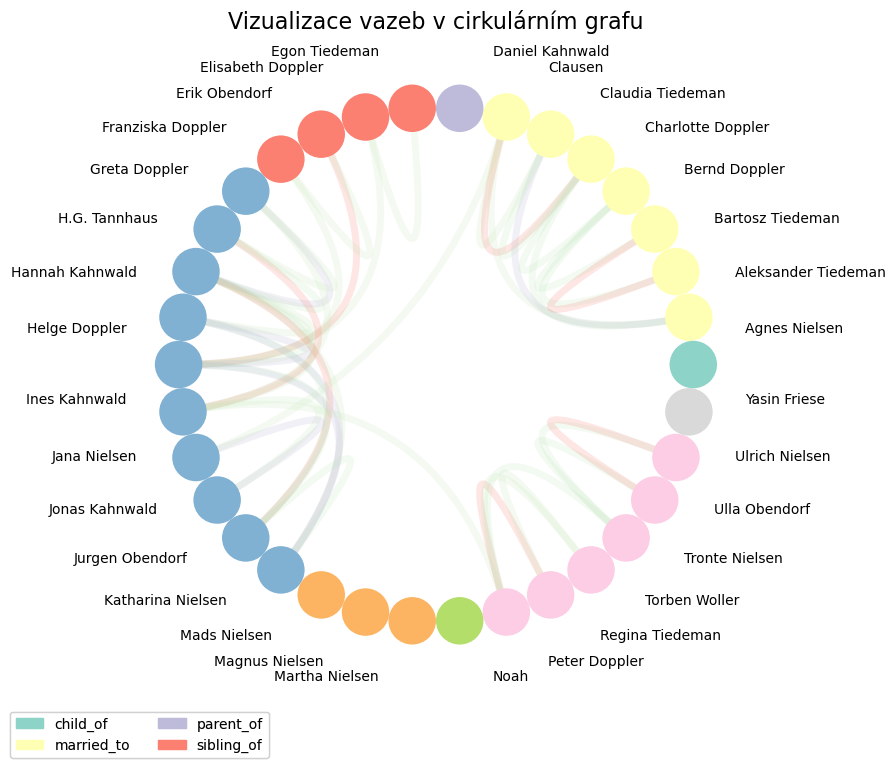

In [12]:
fig = plt.figure(figsize=(9, 8))
ax = plt.gca()

plt.title("Vizualizace vazeb v cirkulárním grafu", fontsize=16, pad=20)

nv.circos(
    family_graph,
    group_by="lastname",
    node_color_by="lastname",
    edge_color_by="kind_id",
    edge_lw_by="w",
)
annotate.circos_group(family_graph, group_by="name", radius_offset=2.25)
annotate.edge_colormapping(
    family_graph,
    color_by="kind",
    ax=ax,
    legend_kwargs={"loc": "lower left", "bbox_to_anchor": (-0.2, -0.15)},
)

plt.show()

🔍 Tento graf obsahuje vesměs stejné informace jako graf matice přechodů, můžeme ale díky němu jednodušeji analyzovat například propojení jednotlivých rodin.

## 🕰 Relace mezi postavami a jednotlivými roky

In [13]:
# vyfiltrujeme postavy, které mají vazbu pouze na jeden rok
nds = [
    node
    for node in year_graph
    if isinstance(node, int) or year_graph.nodes[node]["g"] > 1
]

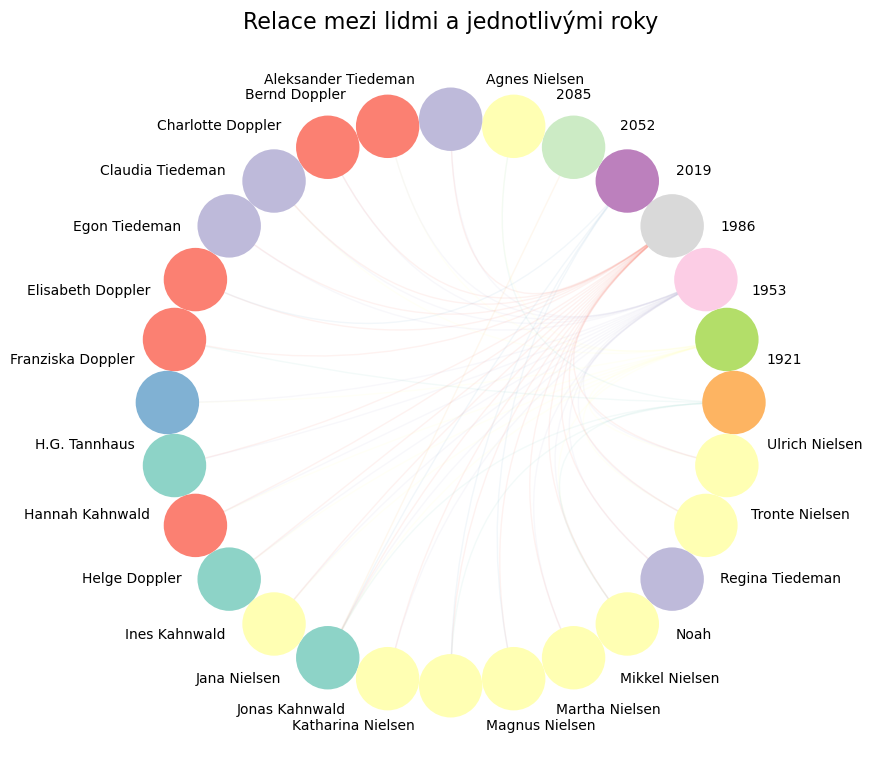

In [14]:
fig, ax = plt.subplots(figsize=(9, 9))
plt.title("Relace mezi lidmi a jednotlivými roky", fontsize=16, pad=20)
nv.circos(
    year_graph.subgraph(nds),
    group_by="name",
    node_color_by="year",
    edge_color_by="y",
)
annotate.circos_group(year_graph.subgraph(nds), group_by="name", radius_offset=1.1)
plt.show()

V tomto posledním grafu vizualizujeme informaci `kdo` figuroval `v jakých letech` v rámci seriálu `Dark`. Díky tomuto grafu můžeme snadno analyzovat, v jakých letech se odehrála podstatná část příběhu a také důležitost jednotlivých postav.

# 🐺 Netwulf
[Netwulf](https://netwulf.readthedocs.io/en/latest/) umožňuje nastavení vizuálních vlastností a layoutu grafu interaktivní formou.

Abychom mohli jednotlivé vrcholy barevně odlišit, je třeba jim nastavit atribut `group`. V našem případě, pokud se jedná o rok, dostane skupinu `year`, pokud se jedná o osobu, nastavíme jako skupinu její příjmení.

In [15]:
for k, v in year_graph.nodes(data=True):
    if v["name"].isnumeric():
        v["group"] = "year"
    else:
        v["group"] = v["name"].split()[-1]

Něco obdobného uděláme s hranami, kterým nastavíme atribut `weight`. Bohužel v datasetu nemáme žádnou informaci o tom, jestli osoby v daném roce existovaly nebo se do něj dostaly pomocí cestování v čase. A tak použijeme index každého roku jako váhu, čistě pro demonstrační účely.

In [16]:
for u, v, attr in year_graph.edges(data=True):
    attr["weight"] = attr["i"]

Po spuštění následující buňky se vám otevře záložka v prohlížeči, ve které můžete pomocí ovládacích prvků a interakce s grafem nastavit jeho vzhled. Až budete hotovi, klikněte na tlačítko `Post to python`.

In [17]:
try:
    network, config = nw.visualize(
        year_graph,
        plot_in_cell_below=False,
    )
except (BrokenPipeError, FileNotFoundError):
    pass

Teď, když jsme si připravili graf, pojďme si ho zobrazit. Abychom graf trochu zpřehlednili, omezíme zobrazení labelů podle stupně.

In [18]:
min_degree = 2

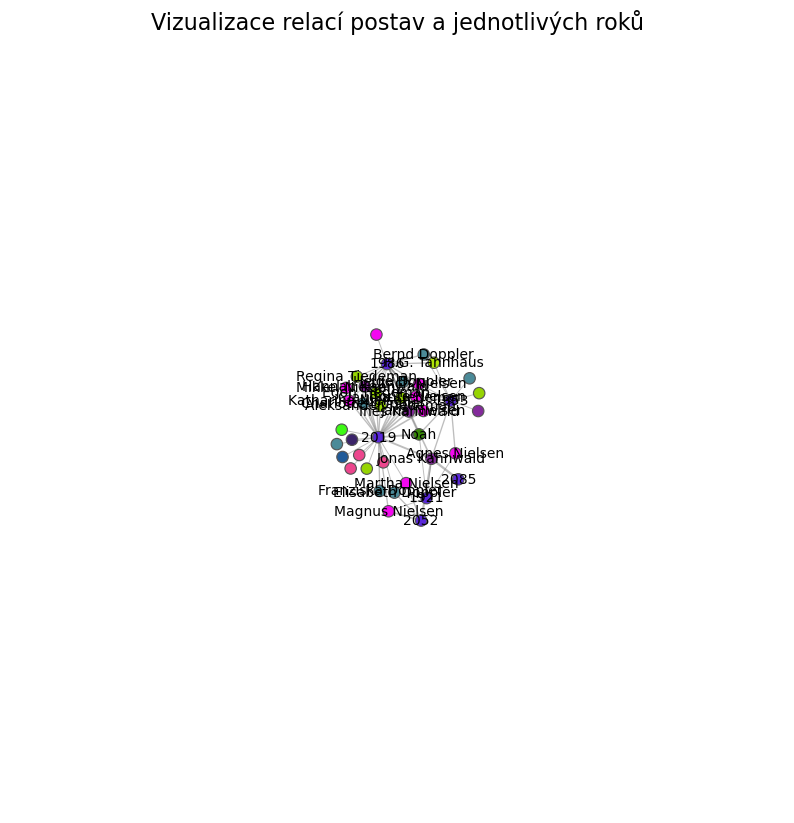

In [19]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 16))

nw.draw_netwulf(network, fig=fig, ax=ax)
ax.set_title("Vizualizace relací postav a jednotlivých roků", size=16)
for node, props in year_graph.nodes(data=True):
    nw.tools.add_node_label(
        ax,
        network,
        node,
        label=node
        if year_graph.degree[node] >= min_degree or props["group"] == "year"
        else "",
    )

for (src, dest, edge_props) in year_graph.edges(data=True):
    nw.tools.add_edge_label(ax, network, (src, dest), label="")

plt.show()

## 🎉 A to je z datasetu Dark všechno! 🎉

Za ⭐️**domácí úkol**⭐️ se zkuste zamyslet, co dalšího byste mohli z těchto dat vizualizovat a jakým způsobem. Pokud zajdete tak daleko, že si nějaký graf dokonce zkusíte 🙊, neváhejte svůj výsledek poslat vyučující 👀.

V posledním 'simulation.ipynb' si můžete spustit **simulaci sociálního experimentu**🕵🏻‍♂️, ve kterém budeme sledovat vývoj relací mezi jednotlivými vrcholy.